<div style="text-align: center;">
<strong>Machine Learning for Scientific Computing and Numerical Analysis - PC 8</strong>
</div>
<div style="text-align: center;">
<strong>Building DeepONets and FNOs from scratch</strong>
</div>
<div style="text-align: center;">
<p>Loïc Gouarin, Samuel Kokh, Hadrien Montanelli</p>
</div>
<div style="text-align: center;">
<i>2024 - 2025</i>
</div>

# 1 Imports and helpers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from math import pi
from tensorflow import keras
from tensorflow.keras import layers

def chebpts(n, dom=[-1, 1]):
    """Return n Chebyshev points of the second kind."""
    
    if n == 1:
        x = np.array([-1])
    else:
        x = -np.cos(np.array([j for j in range(n)])*np.pi/(n-1))
    x = dom[1]*(x + 1)/2 + dom[0]*(1 - x)/2
    
    return x

def quadwts(n, dom=[-1, 1]):
    """Return n weights for Clenshaw-Curtis quadrature."""
    
    c = 2/np.concatenate(([1],  1 - np.arange(2, n, 2)**2), axis=0)
    c = np.concatenate((c, c[int(n/2)-1:0:-1]), axis=0)
    w = np.real(np.fft.ifft(c))
    w[0] = w[0]/2
    w = np.concatenate((w, [w[0]]), axis=0)
    w = (dom[1] - dom[0])/2*w
    
    return w

def compute_burgers_reference(N, eps, T, u0):
    """Solve viscous Burgers' equation on [-1,1] with periodic boundary conditions with a Fourier spectral method and ETDRK4."""
    
    # Grid and initial condition:
    x = np.linspace(-1, 1, N, endpoint=False)
    v = np.fft.fft(u0(x))
    
    # Precompute constants:
    h = 1e-2
    k = np.fft.fftfreq(N, d=1/N) * pi 
    L = -eps * k**2  
    E = np.exp(h * L)
    E2 = np.exp(h * L / 2)
    M = 16
    r = np.exp(1j * pi * (np.arange(1, M + 1) - 0.5) / M)
    LR = h * L[:, None] + r[None, :]
    Q = h * np.real(np.mean((np.exp(LR / 2) - 1) / LR, axis=1))
    f1 = h * np.real(np.mean((-4 - LR + np.exp(LR) * (4 - 3 * LR + LR**2)) / LR**3, axis=1))
    f2 = h * np.real(np.mean((4 + 2 * LR + np.exp(LR) * (-4 + 2 * LR)) / LR**3, axis=1))
    f3 = h * np.real(np.mean((-4 - 3 * LR - LR**2 + np.exp(LR) * (4 - LR)) / LR**3, axis=1))
    g = -0.5j * k
    
    # Time-stepping with exponential integrator:
    t = 0
    f = lambda v: v**2
    while t < T:
        Nv = g * np.fft.fft(f(np.real(np.fft.ifft(v))))
        a = E2 * v + Q * Nv
        Na = g * np.fft.fft(f(np.real(np.fft.ifft(a))))
        b = E2 * v + Q * Na
        Nb = g * np.fft.fft(f(np.real(np.fft.ifft(b))))
        c = E2 * a + Q * (2 * Nb - Nv)
        Nc = g * np.fft.fft(f(np.real(np.fft.ifft(c))))
        v = E * v + Nv * f1 + (Na + Nb) * f2 + Nc * f3
        t += h
    
    u = np.real(np.fft.ifft(v))
    
    return u

# 2 DeepONets

We consider the one-dimensional Poisson equation with homogeneous Dirichlet boundary conditions:

\begin{align}
& -u''(x) = \mu(x), \quad x \in[0,1], \\
& \phantom{-}u(0) = u(1) = 0.
\end{align}

**We want to learn the mapping $\mathcal{N}$ between the right-hand side $\mu$ and the solution $u = \mathcal{N}(\mu)$.**

### Exercise

{exercise}
**Build a DeepONet from scratch and apply it to the above problem.** 

You must:
1. generate $n$ training data pairs $\{(\mu_i,u_i)\}_{i=1}^n$;
2. build the network and find the optimal weights using optimization;
3. test it on unseen data.

*Hints (1 & 3):* You may use right-hand sides of the form
$$
\mu(x) = e^{-5(x - \mu_0)^2},
$$

as in PC 7. You can also train and test on more sophisticated data (e.g., random polynomials or Gaussian processes). For any right-hand side $\mu$, you can compute the corresponding solution $u$ via the Green's function $g$,
$$
u(x) = \int_0^1g(x,y)\mu(y)dy, \qquad g(x,y) = \frac{1}{2}(x + y - \vert y-x\vert)-xy,
$$

and Clenshaw-Curtis quadrature with `quadwts` and `chebpts` (see PC 7).

*Hints (2):* You can create your own DeepONet class via `class DeepONet(tf.keras.Model)`.

**You will be evaluated on:**

- the accuracy and speed of your code;
- your understanding and explanation of the code;
- the presentation of your results.

**Presentation requirements:**

- display your results using graphs (e.g., predictions vs. ground truth);
- measure accuracy using appropriate metrics and discuss the results;
- list all hyperparameters in a well-structured table.

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0021 - val_loss: 6.1592e-05
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7802e-05 - val_loss: 2.8426e-05
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6132e-05 - val_loss: 2.3185e-05
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2139e-05 - val_loss: 2.1525e-05
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0785e-05 - val_loss: 2.0813e-05
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9512e-05 - val_loss: 1.9693e-05
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8971e-05 - val_loss: 1.9175e-05
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7981e-05 - val_loss: 1.6924e-05
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5967e-05 - val_loss: 1.3223e-05
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1424e-05 - val_loss: 8.6015e-06
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1093e-06 -

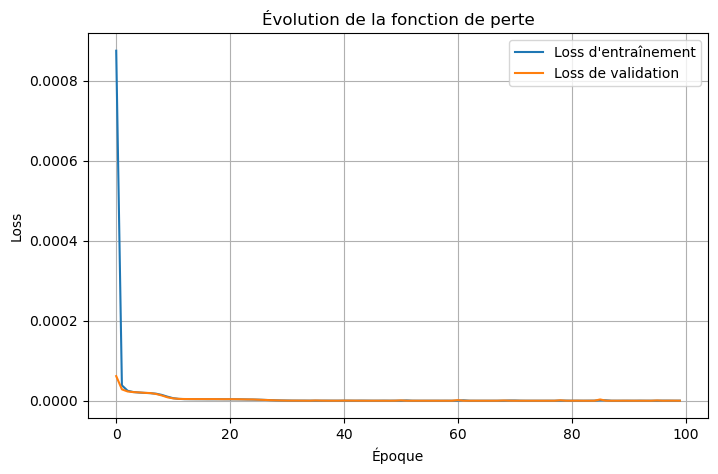

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Erreur relative RMSE sur l'ensemble de test (nouveau): 0.0056 ± 0.0018


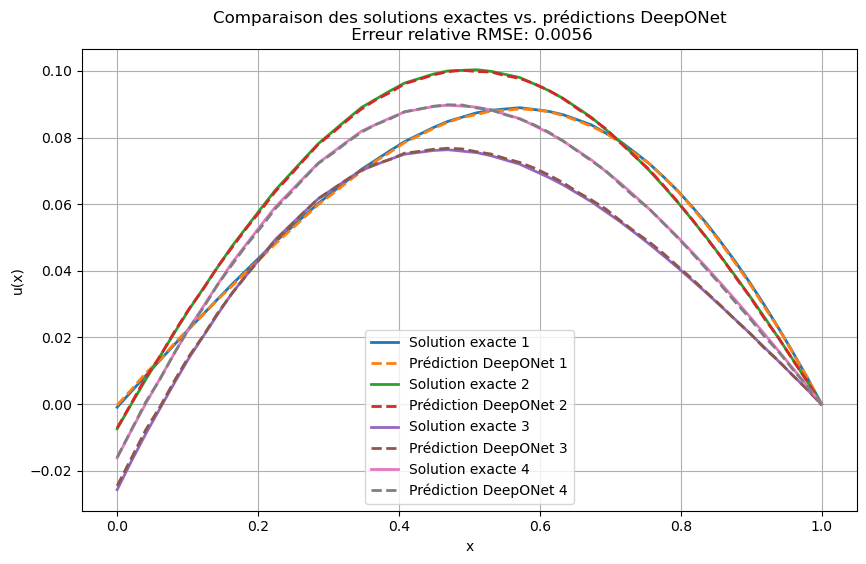

In [ ]:
from scipy.special import eval_chebyt

N_train = 1500
N_test = 200
dp = 50
dv = 50 
mu_type = 'gaussian_exemple'  # choose between 'polynomial' and 'gaussian_exemple'

# Generation of μ(x) functions
def generate_mu_samples(n_samples, type='gaussian_exemple'):
    mu_samples = []
    if type == 'polynomial':
        coeffs_list = [np.random.normal(0, 1, size=10) for _ in range(n_samples)]
        def mu_func(x, coeffs):
            return sum(coeffs[j] * eval_chebyt(j, x) for j in range(10))
        mu_samples = [lambda x, c=coeffs: mu_func(x, c) for coeffs in coeffs_list]
    elif type == 'gaussian_exemple':
        centers = np.random.uniform(0.2, 0.8, n_samples)
        mu_samples = [lambda x, c=c: np.exp(-5 * (x - c) ** 2) for c in centers]
    elif type == 'gaussian_exemple_2':
        centers = np.random.uniform(0.5, 1, n_samples)
        mu_samples = [lambda x, c=c: np.exp(-5 * (x - c) ** 2) for c in centers]
    return mu_samples[:n_samples]

# Data generation
mu_train_funcs = generate_mu_samples(N_train, type=mu_type)
mu_test_funcs = generate_mu_samples(N_test, type=mu_type)
mu_new_funcs= generate_mu_samples(N_test, type=mu_type)
#mu_new_funcs = generate_mu_samples(N_test, type = 'gaussian_exemple_2') : line to uncomment for a test set different from the training set

x_values = np.linspace(0, 1, dp)

X_train_mu = np.array([[mu(x) for x in x_values] for mu in mu_train_funcs])
X_test_mu = np.array([[mu(x) for x in x_values] for mu in mu_test_funcs])
X_new_mu = np.array([[mu(x) for x in x_values] for mu in mu_new_funcs])


def green_function(x, y):
    return 0.5 * (x + y - np.abs(x - y)) - x * y

# Compute the final solution u(x)
def compute_u_final(x, mu_func, n=50):
    y_points = chebpts(n)
    w = quadwts(n)
    g_values = green_function(x, y_points)
    mu_values = np.array([mu_func(y) for y in y_points])
    return np.sum(w * g_values * mu_values)

Y_train_u = np.array([[compute_u_final(x, mu) for x in x_values] for mu in mu_train_funcs])
Y_test_u = np.array([[compute_u_final(x, mu) for x in x_values] for mu in mu_test_funcs])
Y_new_u = np.array([[compute_u_final(x, mu) for x in x_values] for mu in mu_new_funcs])


class DeepONet(keras.Model):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_units=dv):
        super(DeepONet, self).__init__()
        self.branch_net = keras.Sequential([
            layers.Dense(hidden_units, activation='relu'),
            layers.Dense(hidden_units, activation='relu'),
            layers.Dense(hidden_units)
        ])
        self.trunk_net = keras.Sequential([
            layers.Dense(hidden_units, activation='relu'),
            layers.Dense(hidden_units, activation='relu'),
            layers.Dense(hidden_units)
        ])
        self.final_layer = layers.Dot(axes=1)
    
    def call(self, inputs):
        mu_input, x_input = inputs
        branch_out = self.branch_net(mu_input)
        trunk_out = self.trunk_net(x_input)
        return self.final_layer([branch_out, trunk_out])

# Creation and training of the model
deeponet = DeepONet(branch_input_dim=dp, trunk_input_dim=1)
deeponet.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

X_train_x = np.tile(x_values, (N_train, 1))[:, :, np.newaxis]
X_test_x = np.tile(x_values, (N_test, 1))[:, :, np.newaxis]
X_new_x = np.tile(x_values, (N_test, 1))[:, :, np.newaxis]

start_time = time.time()

history = deeponet.fit(
    [X_train_mu, X_train_x], Y_train_u,
    validation_data=([X_test_mu, X_test_x], Y_test_u),
    epochs=100,
    batch_size=32,
    verbose=1
)

training_time = time.time() - start_time
print(f"Temps d'entraînement: {training_time:.2f} secondes")

# Plotting of the loss function
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label="Loss d'entraînement")
plt.plot(history.history['val_loss'], label="Loss de validation")
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()
plt.title('Évolution de la fonction de perte')
plt.grid()
plt.show()

# Evaluation on unseen data
Y_pred_test = deeponet.predict([X_new_mu, X_new_x])

# RMSE calcuation for each exemple
rmse_values = np.sqrt(np.mean((Y_new_u - Y_pred_test) ** 2, axis=1))
# Calculation of the L2 norm of the exact solution for each exemple
norm_values = np.sqrt(np.mean(Y_new_u ** 2, axis=1))
# Calculation of the relative error for each exemple
relative_error_values = rmse_values / norm_values


relative_error_mean = np.mean(relative_error_values)
relative_error_std = np.std(relative_error_values)
print(f"Erreur relative RMSE sur l'ensemble de test (nouveau): {relative_error_mean:.4f} ± {relative_error_std:.4f}")


def plot_multiple_predictions(indices):
    plt.figure(figsize=(10, 6))
    for i, index in enumerate(indices):
        y_pred = Y_pred_test[index]
        plt.plot(x_values, Y_new_u[index], label=f'Solution exacte {i+1}', linewidth=2)
        plt.plot(x_values, y_pred, '--', label=f'Prédiction DeepONet {i+1}', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()
    plt.title(f'Comparaison des solutions exactes vs. prédictions DeepONet\n Erreur relative RMSE: {relative_error_mean:.4f}')
    plt.grid()
    plt.show()

# Plotting of results for 4 random examples
random_indices = np.random.choice(N_test, size=4, replace=False)
plot_multiple_predictions(random_indices)



# 3 FNOs

We consider the one-dimensional viscous Burgers' equation with periodic boundary conditions:

\begin{align}
& u_t(t,x) + \frac{1}{2}(u^2(t,x))_x = \epsilon u_{xx}(t,x), && t\in[0,T], \quad x\in[-1,1], \\
& u(t,-1) = u(t,1), && t\in[0,T], \\
& u_x(t,-1) = u_x(t,1), && t\in[0,T], \\T
& u(0,x) = \mu(x), && x\in[-1,1].
\end{align}

We will take $T=1$ and $\epsilon = 10^{-1}$. 

**We want to learn the mapping $\mathcal{N}$ between the initial condition $\mu$ and the solution $u$ at time $T$, $u(\cdot, T)=\mathcal{N}(\mu)$.**

### Exercise

{exercise}
**Build a FNO from scratch and apply it to the above problem.** 

You must:
1. generate $n$ training data pairs $\{(\mu_i,u_i)\}_{i=1}^n$;
2. build the network and find the optimal weights using optimization;
3. test it on unseen data.

*Hints (1 & 3):* You may use initial conditions of the form
$$
\mu(x) = e^{-100(x - \mu_0)^2},
$$

as in PC 7. You can also train and test on more sophisticated data. For any initial condition $\mu$, you can compute the corresponding solution $u$ with `compute_burgers_reference` (see PC 7).

*Hints (2):* You can create your own FNO class via `FNO(tf.keras.Model)` and your own Fourier layer via `class FourierLayer(layers.Layer)`.

**You will be evaluated on:**

- the accuracy and speed of your code;
- your understanding and explanation of the code;
- the presentation of your results.

**Presentation requirements:**

- display your results using graphs (e.g., predictions vs. ground truth);
- measure accuracy using appropriate metrics and discuss the results;
- list all hyperparameters in a well-structured table.

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0084 - val_loss: 0.0031
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - val_loss: 5.7180e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.9597e-04 - val_loss: 2.7924e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6626e-04 - val_loss: 4.9371e-05
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.4443e-05 - val_loss: 5.8584e-05
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.4842e-05 - val_loss: 2.3037e-05
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1122e-05 - val_loss: 1.2240e-05
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0143e-05 - val_loss: 6.7280e-06
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2839e-06 - val_loss: 4.5748e-06
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.9717e-06 - val_loss: 2.6181e-06
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.4247e-06 - val_loss: 1.8784e-06
Epoch 12/

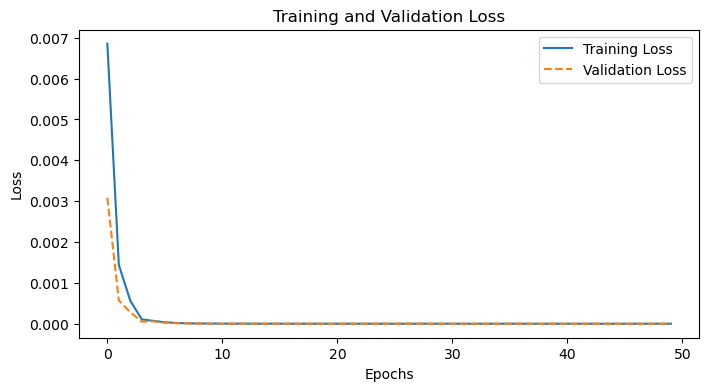

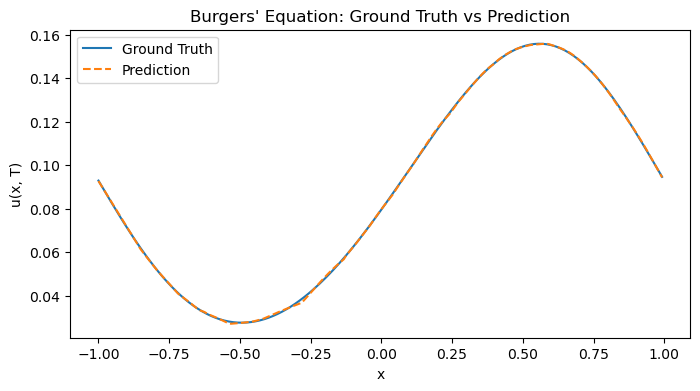

In [ ]:
from tensorflow.keras import models, optimizers, layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import norm
from math import pi

class FourierLayer(layers.Layer):
    def __init__(self, modes, width):
        super(FourierLayer, self).__init__()
        self.modes = modes
        self.width = width

        self.w_linear = self.add_weight(
            shape=(self.width, self.width),
            initializer="random_normal",
            trainable=True,
            name="W_linear"
        )
        self.b_linear = self.add_weight(
            shape=(self.width,),
            initializer="zeros",
            trainable=True,
            name="b_linear"
        )

        # Complex weights for convolution
        self.weights_real = self.add_weight(
            shape=(self.width, self.width, self.modes),
            initializer="random_normal",
            trainable=True,
            name="w_real"
        )
        self.weights_imag = self.add_weight(
            shape=(self.width, self.width, self.modes),
            initializer="random_normal",
            trainable=True,
            name="w_imag"
        )

    def call(self, x):
        x_linear = tf.einsum('bij,jk->bik', x, self.w_linear) + self.b_linear
        x_perm = tf.transpose(x, perm=[0, 2, 1])
        x_ft = tf.signal.rfft(x_perm)
        x_ft_cut = x_ft[:, :, :self.modes]
        weight = tf.complex(self.weights_real, self.weights_imag)
        out_ft_low = tf.einsum('bjm,jim->bim', x_ft_cut, weight)  
        n_fft = tf.shape(x_ft)[-1]
        pad_size = n_fft - self.modes
        zeros = tf.zeros((tf.shape(x)[0], self.width, pad_size), dtype=tf.complex64)
        out_ft = tf.concat([out_ft_low, zeros], axis=-1)
        x_ifft = tf.signal.irfft(out_ft, fft_length=[tf.shape(x)[1]])  
        x_out = tf.transpose(x_ifft, perm=[0, 2, 1])
        return tf.nn.relu(x_linear + x_out)

class FNO(tf.keras.Model):
    def __init__(self, modes, width, num_layers=4):
        super(FNO, self).__init__()
        self.modes = modes
        self.width = width
        self.num_layers = num_layers
        self.lifting = layers.Dense(width) 
        self.fourier_layers = [FourierLayer(modes, width) for _ in range(num_layers)]
        self.projection = layers.Dense(1)

    def call(self, x):
        x = self.lifting(x)
        for f_layer in self.fourier_layers:
            x = f_layer(x)
        x = self.projection(x)
        return x

def compute_errors(y_true, y_pred):
    y_true, y_pred = np.squeeze(y_true), np.squeeze(y_pred)
    error_L2 = norm(y_true - y_pred, 2) / norm(y_true, 2)
    error_Linf = norm(y_true - y_pred, np.inf) / norm(y_true, np.inf)
    return error_L2, error_Linf

def generate_burgers_data(n_samples, N, T, eps):
    x_grid = np.linspace(-1, 1, N, endpoint=False)
    u0_data = np.zeros((n_samples, N, 1))
    uT_data = np.zeros((n_samples, N, 1))
    
    for i in range(n_samples):
        c = np.random.uniform(-0.5, 0.5)
        u0_func = lambda x, c=c: np.exp(-100 * (x - c) ** 2)
        u0_sample = u0_func(x_grid)
        uT_sample = compute_burgers_reference(N, eps, T, u0_func)
        
        u0_data[i, :, 0] = u0_sample
        uT_data[i, :, 0] = uT_sample

    return x_grid, u0_data, uT_data

N, T, eps = 256, 1.0, 0.1
n_train, n_test, epochs, batch_size = 100, 20, 50, 10
learning_rate, modes, width, num_layers = 1e-3, 4, 16, 2
x_grid, u0_train, uT_train = generate_burgers_data(n_train, N, T, eps)
_, u0_test, uT_test = generate_burgers_data(n_test, N, T, eps)

model = FNO(modes, width, num_layers)
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mse')
history = model.fit(u0_train, uT_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

uT_pred_test = model.predict(u0_test)
error_L2, error_Linf = compute_errors(uT_test, uT_pred_test)
print(f"Test L2 Error: {error_L2:.4e}")
print(f"Test L∞ Error: {error_Linf:.4e}")

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(x_grid, uT_test[0, :, 0], label="Ground Truth")
plt.plot(x_grid, uT_pred_test[0, :, 0], '--', label="Prediction")
plt.xlabel("x")
plt.ylabel("u(x, T)")
plt.title("Burgers' Equation: Ground Truth vs Prediction")
plt.legend()
plt.show()